In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [15]:
import os
import numpy as np
import librosa
from tqdm import tqdm
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

In [22]:
# ==============================
# Load Dataset & Fix Shape Issue
# ==============================
def load_audio_data(data_dir, sr=22050, n_mels=128, fixed_width=260):
    audio_files = []
    labels = []
    class_names = sorted(os.listdir(data_dir))  # Get label names

    print("🔄 Loading Dataset...")
    for class_label in tqdm(class_names, desc="Processing Classes"):  # Progress bar
        class_path = os.path.join(data_dir, class_label)
        if os.path.isdir(class_path):
            for file in os.listdir(class_path):
                if file.endswith(".wav") or file.endswith(".mp3"):
                    file_path = os.path.join(class_path, file)
                    y, _ = librosa.load(file_path, sr=sr)  # Load audio
                    mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels)
                    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)

                    # Normalize
                    # mel_spec_db = (mel_spec_db - mel_spec_db.min()) / (mel_spec_db.max() - mel_spec_db.min())

                    # ==============================
                    # **Fix Shape: Pad or Crop to fixed_width**
                    # ==============================
                    if mel_spec_db.shape[1] < fixed_width:
                        pad_width = fixed_width - mel_spec_db.shape[1]
                        mel_spec_db = np.pad(mel_spec_db, ((0, 0), (0, pad_width)), mode='constant')
                    else:
                        mel_spec_db = mel_spec_db[:, :fixed_width]  # Crop if too long

                    # mel_spec_db = np.expand_dims(mel_spec_db, axis=-1)  # Add channel dimension

                    audio_files.append(mel_spec_db)
                    labels.append(class_label)

    print("✅ Dataset Loaded Successfully!")
    return np.array(audio_files), np.array(labels), class_names

In [17]:
file_path = "/content/drive/MyDrive/IOT/SoundClasification/Dataset/Single/single_30.wav"
sr = 22050
n_mels = 128
fixed_width=260
y, _ = librosa.load(file_path, sr=sr)  # Load audio
mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels)
mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)

# Normalize
# mel_spec_db = (mel_spec_db - mel_spec_db.min()) / (mel_spec_db.max() - mel_spec_db.min())

# ==============================
# **Fix Shape: Pad or Crop to fixed_width**
# ==============================
if mel_spec_db.shape[1] < fixed_width:
    pad_width = fixed_width - mel_spec_db.shape[1]
    mel_spec_db = np.pad(mel_spec_db, ((0, 0), (0, pad_width)), mode='constant')
else:
    mel_spec_db = mel_spec_db[:, :fixed_width]  # Crop if too long

mel_spec_db = np.expand_dims(mel_spec_db, axis=-1)
print(mel_spec_db.shape)

(128, 260, 1)


In [23]:
# ==============================
# CNN Patch Embedding Model
# ==============================
def build_cnn_patch_embedding(input_shape, embed_dim=256):
    model = tf.keras.Sequential([
      tf.keras.layers.Input(shape=(128, 260, 1)),  # Fix input shape (H, W, C)
      tf.keras.layers.Conv2D(32, (3,3), activation='relu', padding='same'),
      tf.keras.layers.MaxPooling2D((2,2)),
      tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='same'),
      tf.keras.layers.MaxPooling2D((2,2)),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(128, activation='relu'),
      tf.keras.layers.Dense(64, activation='relu'),
      tf.keras.layers.Dense(8, activation='softmax')  # Adjust based on num_classes
    ])
    return model


In [24]:
data_dir = "/content/drive/MyDrive/IOT/SoundClasification/Dataset"  # Replace with your dataset path
X, y, class_names = load_audio_data(data_dir)

# Convert labels to numerical format
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)  # Encode labels as integers

# One-hot encode labels
y_encoded = to_categorical(y_encoded)

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)


model = build_cnn_patch_embedding(input_shape=(128, 260, 1), embed_dim=256)

# Compile the model
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

# Evaluate the model on the test data
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc:.4f}")

🔄 Loading Dataset...


Processing Classes: 100%|██████████| 8/8 [00:08<00:00,  1.02s/it]


✅ Dataset Loaded Successfully!
Epoch 1/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 227ms/step - accuracy: 0.1565 - loss: 83.7576 - val_accuracy: 0.5000 - val_loss: 1.7883
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - accuracy: 0.5093 - loss: 1.4943 - val_accuracy: 0.6250 - val_loss: 0.9511
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.7705 - loss: 0.7215 - val_accuracy: 0.7625 - val_loss: 0.7536
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.9530 - loss: 0.2108 - val_accuracy: 0.8125 - val_loss: 0.7026
Epoch 5/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.9948 - loss: 0.0576 - val_accuracy: 0.8375 - val_loss: 0.6501
Epoch 6/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.9950 - loss: 0.0289 - val_accuracy: 0.8750 - val_loss: 0.6697
Epoch 7/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.9942 - loss: 0.0108 - val_accuracy: 0.9250 - val_loss: 0.6028
Epoch 8/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 1.0000 - loss: 

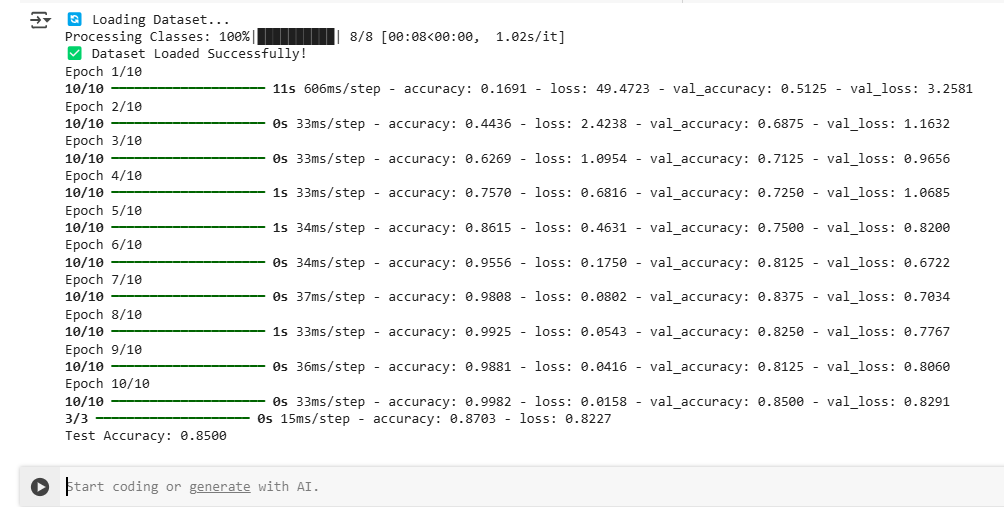